In [15]:
# ===============================
# Tail Risk Data Preparation
# ===============================

import yfinance as yf
import pandas as pd

# -------------------------------
# Parameters (LOCKED FOR NOW)
# -------------------------------
START_DATE = "1990-01-01"
HORIZON = 10        # days ahead
THRESHOLD = -0.05  # -5% loss

# -------------------------------
# Step 1: Download S&P 500 Data
# -------------------------------
print("Downloading S&P 500 data...")

df = yf.download("^GSPC", start=START_DATE)
df.columns = df.columns.get_level_values(0)
# Keep only what we need
df = df[['Close', 'Volume']]
df.dropna(inplace=True)

print(f"Data shape after download: {df.shape}")

# -------------------------------
# Step 2: Create Forward Returns
# -------------------------------
df['forward_return'] = df['Close'].shift(-HORIZON) / df['Close'] - 1

# -------------------------------
# Step 3: Create Tail Risk Label
# -------------------------------
df['tail_event'] = (df['forward_return'] <= THRESHOLD).astype(int)

# Drop last HORIZON rows (no future data)
df = df.iloc[:-HORIZON]

# -------------------------------
# Step 4: Sanity Checks
# -------------------------------
positive_rate = df['tail_event'].mean()
num_events = df['tail_event'].sum()
total = len(df)

print("\n===== Tail Risk Summary =====")
print(f"Horizon        : {HORIZON} days")
print(f"Threshold      : {THRESHOLD * 100:.1f}%")
print(f"Total samples  : {total}")
print(f"Tail events    : {num_events}")
print(f"Event rate     : {positive_rate:.3%}")
print("=============================\n")

# -------------------------------
# Step 5: Save to CSV
# -------------------------------
df.to_csv("sp500_tail_risk_data.csv")
print("Saved processed data to sp500_tail_risk_data.csv")


/tmp/ipykernel_55/4002970752.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start=START_DATE)
[*********************100%***********************]  1 of 1 completed

Data shape after download: (9060, 2)

===== Tail Risk Summary =====
Horizon        : 10 days
Threshold      : -5.0%
Total samples  : 9050
Tail events    : 411
Event rate     : 4.541%

Saved processed data to sp500_tail_risk_data.csv


In [16]:
import numpy as np

df['log_return_1d'] = np.log(df['Close'] / df['Close'].shift(1))

df['vol_10'] = df['log_return_1d'].rolling(10).std()
df['vol_20'] = df['log_return_1d'].rolling(20).std()
df['vol_60'] = df['log_return_1d'].rolling(60).std()

rolling_max_20 = df['Close'].rolling(20).max()
df['drawdown_20'] = df['Close'] / rolling_max_20 - 1

df['mom_10'] = df['Close'] / df['Close'].shift(10) - 1
df['mom_50'] = df['Close'] / df['Close'].shift(50) - 1

vol_mean_20 = df['Volume'].rolling(20).mean()
df['volume_ratio_20'] = df['Volume'] / vol_mean_20

feature_cols = [
    'log_return_1d',
    'vol_10', 'vol_20', 'vol_60',
    'drawdown_20',
    'mom_10', 'mom_50',
    'volume_ratio_20'
]

df = df.dropna()
print("Columns after feature engineering:")
print(df.columns.tolist())


Columns after feature engineering:
['Close', 'Volume', 'forward_return', 'tail_event', 'log_return_1d', 'vol_10', 'vol_20', 'vol_60', 'drawdown_20', 'mom_10', 'mom_50', 'volume_ratio_20']


In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------------------------
# Create X (features) and y (labels)
# -------------------------
X = df[feature_cols].values
y = df['tail_event'].values

# -------------------------
# Time-based split (NO SHUFFLING)
# -------------------------
n = len(df)

train_end = int(0.70 * n)
val_end   = int(0.85 * n)

X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

# -------------------------
# Sanity check: tail event rate
# -------------------------
print("\nTail event rate:")
print("Train:", y_train.mean())
print("Val  :", y_val.mean())
print("Test :", y_test.mean())

# -------------------------
# Feature scaling (FIT ON TRAIN ONLY)
# -------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

Shapes:
X_train: (6293, 8) y_train: (6293,)
X_val  : (1348, 8) y_val  : (1348,)
X_test : (1349, 8) y_test : (1349,)

Tail event rate:
Train: 0.04401716192594947
Val  : 0.04821958456973294
Test : 0.04670126019273536


In [18]:
# ===============================
# STEP 5: NEURAL NETWORK TRAINING
# ===============================

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_class_weight

# -------------------------------
# 1. Compute class weights (TRAIN ONLY)
# -------------------------------
classes = np.array([0, 1])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weight_dict)

# -------------------------------
# 2. Build the neural network
# -------------------------------
model = Sequential([
    Dense(32, activation='relu',
          input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# -------------------------------
# 3. Compile the model
# -------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['Recall']
)

# -------------------------------
# 4. Train (TRAIN + VALIDATION ONLY)
# -------------------------------
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

# -------------------------------
# 5. Validation predictions (for tuning)
# -------------------------------
y_val_proba = model.predict(X_val_scaled)

# -------------------------------
# 6. FINAL TEST EVALUATION (ONCE)
# -------------------------------
test_loss, test_recall = model.evaluate(
    X_test_scaled,
    y_test,
    verbose=1
)

print(f"\nFinal Test Recall: {test_recall:.3f}")

# -------------------------------
# 7. Test probabilities (for dashboard / analysis)
# -------------------------------
y_test_proba = model.predict(X_test_scaled)
print("Min probability :", y_test_proba.min())
print("Max probability :", y_test_proba.max())
print("Mean probability:", y_test_proba.mean())
today_risk = y_test_proba[-1][0]
print(f"Tail risk over next 10 days: {today_risk:.3f}")

Class weights: {0: np.float64(0.5230219414893617), 1: np.float64(11.359205776173285)}
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - Recall: 0.8010 - loss: 0.6373 - val_Recall: 0.3385 - val_loss: 0.5376
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.6970 - loss: 0.5922 - val_Recall: 0.3846 - val_loss: 0.5264
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7571 - loss: 0.5440 - val_Recall: 0.4308 - val_loss: 0.5678
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7751 - loss: 0.5355 - val_Recall: 0.4000 - val_loss: 0.4966
Epoch 5/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7212 - loss: 0.5416 - val_Recall: 0.4308 - val_loss: 0.5109
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7520 - loss: 0.4968 - val_Recall: 0.4462 - val_loss: 0.5342
Epoch 7/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7375 - loss: 0.5701 - val_Recall: 0.4308 - val_loss: 0.5155
Epoch 8/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7946 - loss: 0.5156 - val_Recall: 0.4154 - val_loss: 0.5093
Epoch 9/30
197/197 

In [19]:
import numpy as np
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    brier_score_loss
)

# Decision threshold
THRESHOLD = 0.25
y_test_pred = (y_test_proba >= THRESHOLD).astype(int)

# ---- Metrics ----
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)
brier = brier_score_loss(y_test, y_test_proba)

# ---- Print results ----
print("Evaluation Metrics")
print("------------------")
print(f"Precision   : {precision:.4f}")
print(f"Recall      : {recall:.4f}")
print(f"ROC-AUC     : {roc_auc:.4f}")
print(f"Brier Score : {brier:.4f}")

Evaluation Metrics
------------------
Precision   : 0.0617
Recall      : 0.8413
ROC-AUC     : 0.7066
Brier Score : 0.1763


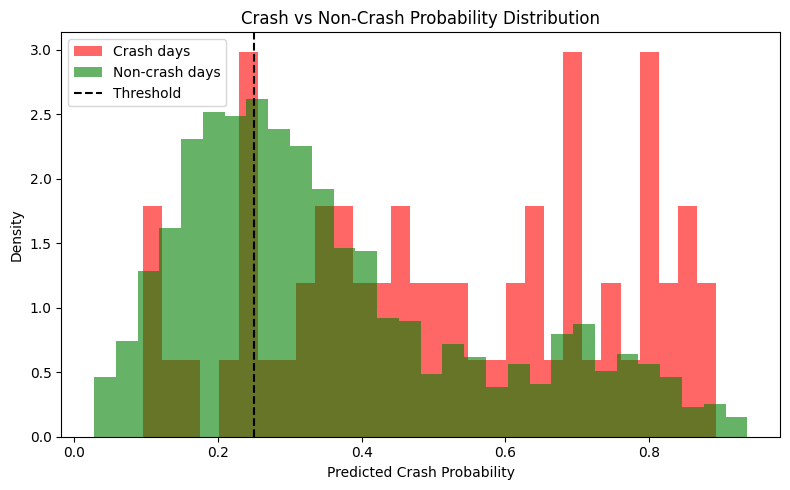

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plt.hist(
    y_test_proba[y_test == 1],
    bins=30,
    alpha=0.6,
    label="Crash days",
    color="red",
    density=True
)

plt.hist(
    y_test_proba[y_test == 0],
    bins=30,
    alpha=0.6,
    label="Non-crash days",
    color="green",
    density=True
)

plt.axvline(0.25, color="black", linestyle="--", label="Threshold")

plt.xlabel("Predicted Crash Probability")
plt.ylabel("Density")
plt.title("Crash vs Non-Crash Probability Distribution")
plt.legend()
plt.tight_layout()
plt.show()


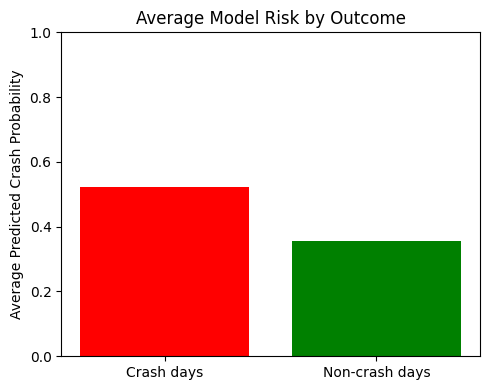

In [21]:
import numpy as np
import matplotlib.pyplot as plt

avg_crash = y_test_proba[y_test == 1].mean()
avg_noncrash = y_test_proba[y_test == 0].mean()

plt.figure(figsize=(5,4))
plt.bar(
    ["Crash days", "Non-crash days"],
    [avg_crash, avg_noncrash],
    color=["red", "green"]
)

plt.ylabel("Average Predicted Crash Probability")
plt.title("Average Model Risk by Outcome")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


/tmp/ipykernel_55/2353176710.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_crash_rate = df_crash_rate.groupby("risk_bucket")["crash"].mean()


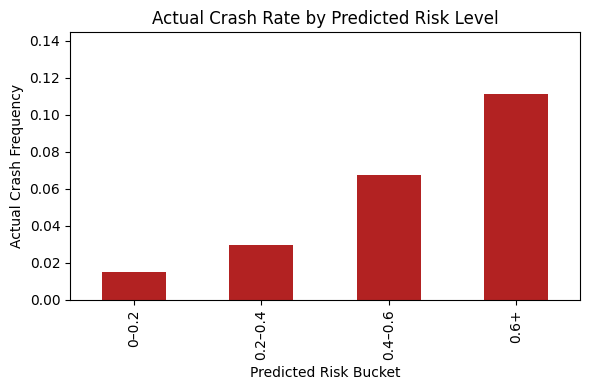

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

y_test_proba = y_test_proba.ravel()

# Create dataframe
df_crash_rate = pd.DataFrame({
    "prob": y_test_proba,
    "crash": y_test
})

# Risk buckets
bins = [0, 0.2, 0.4, 0.6, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6+"]

df_crash_rate["risk_bucket"] = pd.cut(df_crash_rate["prob"], bins=bins, labels=labels)

# Compute actual crash rate per bucket
bucket_crash_rate = df_crash_rate.groupby("risk_bucket")["crash"].mean()

# Plot
bucket_crash_rate.plot(
    kind="bar",
    color="firebrick",
    figsize=(6,4)
)

plt.ylabel("Actual Crash Frequency")
plt.xlabel("Predicted Risk Bucket")
plt.title("Actual Crash Rate by Predicted Risk Level")
plt.ylim(0, bucket_crash_rate.max() * 1.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_55/1214209393.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("risk_bucket")["forward_return"]


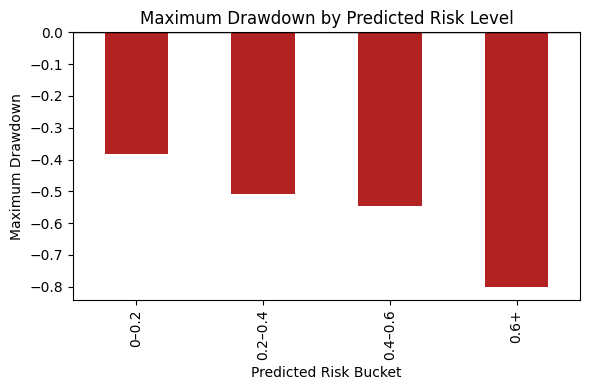

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Ensure predictions are 1D
# -------------------------------
y_test_proba = np.asarray(y_test_proba).ravel()
n_test = len(y_test_proba)

# -------------------------------
# 2. Align test rows
# -------------------------------
df_tail = df.tail(n_test).copy()
df_tail["prob"] = y_test_proba

# -------------------------------
# 3. Risk buckets
# -------------------------------
bins = [0.0, 0.2, 0.4, 0.6, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6+"]

df_tail["risk_bucket"] = pd.cut(
    df_tail["prob"],
    bins=bins,
    labels=labels
)

# -------------------------------
# 4. Compute max drawdown per bucket
# -------------------------------
def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

bucket_drawdowns = (
    df_tail
    .groupby("risk_bucket")["forward_return"]
    .apply(max_drawdown)
)

# -------------------------------
# 5. Plot
# -------------------------------
bucket_drawdowns.plot(
    kind="bar",
    figsize=(6,4),
    color="firebrick"
)

plt.ylabel("Maximum Drawdown")
plt.xlabel("Predicted Risk Bucket")
plt.title("Maximum Drawdown by Predicted Risk Level")
plt.axhline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()


In [24]:
# Save model
model.save("tail_risk_model.keras")

# Save scaler (if used)
import joblib
joblib.dump(scaler, "scaler.pkl")
feature_cols = [
    'log_return_1d',
    'vol_10', 'vol_20', 'vol_60',
    'drawdown_20',
    'mom_10', 'mom_50',
    'volume_ratio_20'
]
joblib.dump(feature_cols, "features.pkl")
# Save processed dataframe (must include forward_return)
df.to_csv("processed_data.csv", index=False)